In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip uninstall -y tensorflow numpy

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [2]:
# Install compatible versions
!pip install numpy==1.26.4 tensorflow==2.15.0
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully unin

In [2]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Word cloud for data visualization
from wordcloud import WordCloud


# Regular expressions and string handling
import re
import string

# Natural Language Toolkit (NLTK) for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('punkt')           # Tokenizer models
nltk.download('punkt_tab')
nltk.download('stopwords')       # Stopword list
nltk.download('wordnet')         # Lemmatizer dictionary
nltk.download('omw-1.4')         # Lemmatizer wordnet data



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
# Load dataset
data = pd.read_csv("/content/drive/MyDrive/AI and ML/Assignment 2/10.True vs. Fake News Dataset/truevsfakenews.csv")

# Display initial data
print("Original Dataset:")
print(data.head())
print(f"Dataset shape: {data.shape}")

# Check actual label values BEFORE processing
print("\n Raw label values (before cleaning):")
print(data['label'].unique())
print(data['label'].value_counts())


Original Dataset:
                                                text label
0  WASHINGTON (Reuters) - The Republican and Demo...  true
1  Women should get as far away from Oklahoma as ...  fake
2  Another huge crowd of Americans tuned in last ...  fake
3  Donald Trump is desperate to stop the investig...  fake
4  (Reuters) - Planned Parenthood, the U.S. medic...  true
Dataset shape: (20000, 2)

 Raw label values (before cleaning):
['true' 'fake']
label
true    10000
fake    10000
Name: count, dtype: int64



 Cleaned label distribution (0 = Real, 1 = Fake):
label
0    10000
1    10000
Name: count, dtype: int64

 Total unique words in corpus after cleaning: 122,752


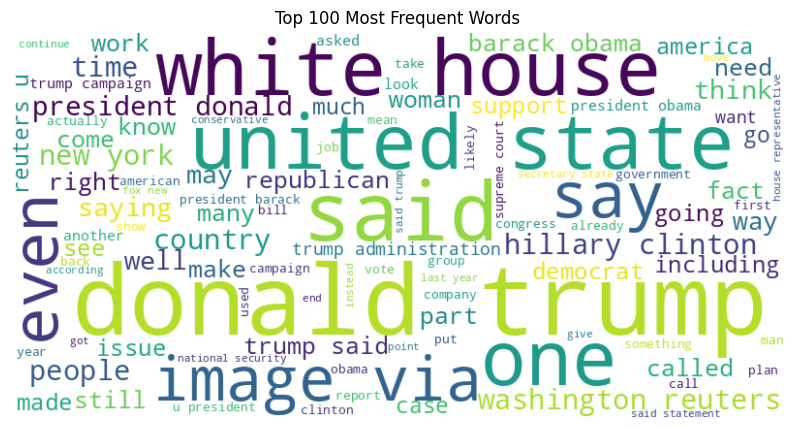

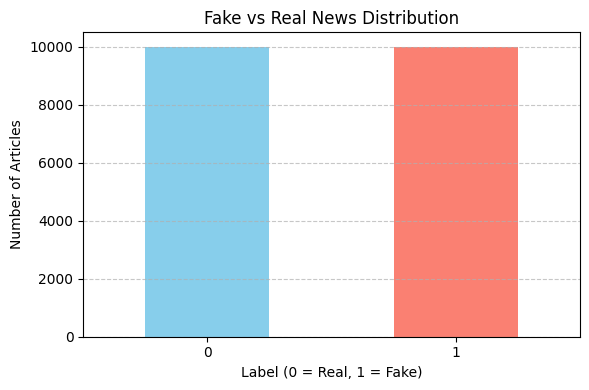

In [4]:
# Step 2: Clean and map labels
data['label'] = data['label'].astype(str).str.strip().str.lower()
data = data[data['label'].isin(['true', 'fake'])]  # Just in case
data['label'] = data['label'].map({'true': 0, 'fake': 1})

print("\n Cleaned label distribution (0 = Real, 1 = Fake):")
print(data['label'].value_counts())

# Step 3: Preprocess text
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Contraction mapping
contractions_dict = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "can't": "cannot", "won't": "will not", "shouldn't": "should not",
    "isn't": "is not", "aren't": "are not", "wasn't": "was not",
    "weren't": "were not", "hasn't": "has not", "haven't": "have not",
    "hadn't": "had not", "mightn't": "might not", "mustn't": "must not",
    "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
    "it's": "it is", "we're": "we are", "they're": "they are",
    "i've": "i have", "you've": "you have", "we've": "we have",
    "they've": "they have", "i'll": "i will", "you'll": "you will",
    "he'll": "he will", "she'll": "she will", "we'll": "we will",
    "they'll": "they will"
}

# Compile regex pattern for contractions
contraction_pattern = re.compile(
    r'\b({})\b'.format('|'.join(re.escape(k) for k in contractions_dict.keys())),
    flags=re.IGNORECASE
)

# Function to fix Unicode apostrophe replacements like â€™
def fix_unicode_artifacts(text):
    # Replace common Unicode misinterpretations
    text = text.replace("â€™", "'") \
              .replace("â€œ", "“") \
              .replace("â€", "”") \
              .replace("â€˜", "‘") \
              .replace("â€“", "–") \
              .replace("â€”", "—") \
              .replace("â‚¬", "€") \
              .replace("Â", "")  # Removes stray Â characters
    return text

# Expand contractions
def expand_contractions(text):
    def replace(match):
        word = match.group(0)
        return contractions_dict.get(word.lower(), word)
    return contraction_pattern.sub(replace, text)

# Full preprocessing function
def preprocess_text(text):
    # Step 1: Fix Unicode artifacts
    text = fix_unicode_artifacts(text)

    # Step 2: Lowercase
    text = text.lower()

    # Step 3: Expand contractions
    text = expand_contractions(text)

    # Step 4: Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Step 5: Remove @mentions and #hashtags
    text = re.sub(r'@\w+|#', '', text)

    # Step 6: Remove punctuation (except apostrophes inside words)
    text = re.sub(r'[^\w\s\']', '', text)

    # Step 7: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 8: Tokenize and remove stopwords
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

data['cleaned_text'] = data['text'].apply(preprocess_text)

# Step 4: Count unique words
all_words = []

for text in data['cleaned_text']:
    words = text.split()
    all_words.extend(words)

unique_words = set(all_words)
total_unique_words = len(unique_words)

print(f"\n Total unique words in corpus after cleaning: {total_unique_words:,}")

# Step 5: WordCloud
all_words_cloud = ' '.join(data['cleaned_text'])

if all_words_cloud.strip():
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words_cloud)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Top 100 Most Frequent Words')
    plt.show()
else:
    print(" No words available to generate a WordCloud.")

# Step 6: Bar chart of label distribution
label_counts = data['label'].value_counts()
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Fake vs Real News Distribution')
plt.xlabel('Label (0 = Real, 1 = Fake)')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['label'],
    test_size=0.2,
    random_state=42
)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))
print(f"Padding sequences to length: {max_len}")

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Define vocab size and embedding dimension
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128



Padding sequences to length: 497


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.initializers import Constant

# Build Models

In [10]:
# RNN Model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nRNN Model Summary:")
rnn_model.summary()


RNN Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 497, 128)          13687168  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 13699585 (52.26 MB)
Trainable params: 13699585 (52.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nLSTM Model Summary:")
lstm_model.summary()


LSTM Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 497, 128)          13687168  
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13736641 (52.40 MB)
Trainable params: 13736641 (52.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
import gensim.downloader as api

# Word2Vec LSTM Model
print("Loading Word2Vec model...")
embedding_model = api.load("word2vec-google-news-300")
embedding_dim_w2v = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim_w2v))
for word, i in tokenizer.word_index.items():
    if word in embedding_model:
        embedding_vector = embedding_model[word]
        if len(embedding_vector) == embedding_dim_w2v:
            embedding_matrix[i] = embedding_vector

word2vec_lstm_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim_w2v,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
word2vec_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nWord2Vec LSTM Model Summary:")
word2vec_lstm_model.summary()

Loading Word2Vec model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded

Word2Vec LSTM Model Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 497, 300)          32079300  
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 32172805 (122.73 MB)
Trainable params: 93505 (365.25 KB)
Non-trainable params: 32079300 (122.37 MB)
_________________________________________________________________


# Training Setup

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Use full dataset
X_train_sample = X_train_pad
y_train_sample = y_train
X_test_sample = X_test_pad
y_test_sample = y_test

# Train RNN
print("\nTraining RNN model...")
rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop, checkpoint]
)




Training RNN model...
Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5299

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 118s 468ms/step - loss: 0.6904 - accuracy: 0.5299 - val_loss: 0.6835 - val_accuracy: 0.5562
Epoch 2/20
250/250 [==============================] - 113s 451ms/step - loss: 0.6911 - accuracy: 0.5318 - val_loss: 0.6845 - val_accuracy: 0.5375
Epoch 3/20
250/250 [==============================] - 115s 459ms/step - loss: 0.6840 - accuracy: 0.5264 - val_loss: 0.6878 - val_accuracy: 0.5173
Epoch 4/20
250/250 [==============================] - 114s 456ms/step - loss: 0.6752 - accuracy: 0.5439 - val_loss: 0.6604 - val_accuracy: 0.6392
Epoch 5/20
250/250 [==============================] - 111s 444ms/step - loss: 0.5954 - accuracy: 0.6852 - val_loss: 0.5750 - val_accuracy: 0.7333
Epoch 6/20
250/250 [==============================] - 113s 454ms/step - loss: 0.5714 - accuracy: 0.7285 - val_loss: 0.5921 - val_accuracy: 0.7147
Epoch 7/20
250/250 [==============================] - 114s 455ms/step - loss: 0.5447 - accuracy: 0.7564 - val_loss: 0.5496 - val_accura

In [15]:
# Train LSTM
print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop, checkpoint]
)




Training LSTM model...
Epoch 1/20
250/250 [==============================] - 211s 836ms/step - loss: 0.6830 - accuracy: 0.5353 - val_loss: 0.6739 - val_accuracy: 0.5540
Epoch 2/20
250/250 [==============================] - 208s 834ms/step - loss: 0.6957 - accuracy: 0.5353 - val_loss: 0.6734 - val_accuracy: 0.5552
Epoch 3/20
250/250 [==============================] - 205s 822ms/step - loss: 0.6686 - accuracy: 0.5396 - val_loss: 0.6738 - val_accuracy: 0.5520
Epoch 4/20
250/250 [==============================] - 209s 835ms/step - loss: 0.6624 - accuracy: 0.5397 - val_loss: 0.6749 - val_accuracy: 0.5550
Epoch 5/20
250/250 [==============================] - 208s 831ms/step - loss: 0.6554 - accuracy: 0.5566 - val_loss: 0.6433 - val_accuracy: 0.6187
Epoch 6/20
250/250 [==============================] - 205s 820ms/step - loss: 0.3333 - accuracy: 0.8705 - val_loss: 0.1848 - val_accuracy: 0.9555
Epoch 7/20
250/250 [==============================] - 209s 837ms/step - loss: 0.1379 - accuracy: 0.9

In [16]:
# Train Word2Vec LSTM
print("\nTraining LSTM with Word2Vec Embeddings...")
word2vec_lstm_history = word2vec_lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop, checkpoint]
)


Training LSTM with Word2Vec Embeddings...
Epoch 1/10
250/250 [==============================] - 148s 587ms/step - loss: 0.6798 - accuracy: 0.5422 - val_loss: 0.6703 - val_accuracy: 0.5748
Epoch 2/10
250/250 [==============================] - 144s 578ms/step - loss: 0.4052 - accuracy: 0.8111 - val_loss: 0.1963 - val_accuracy: 0.9445
Epoch 3/10
250/250 [==============================] - 146s 583ms/step - loss: 0.2264 - accuracy: 0.9361 - val_loss: 0.2485 - val_accuracy: 0.9212
Epoch 4/10
250/250 [==============================] - 146s 585ms/step - loss: 0.1829 - accuracy: 0.9526 - val_loss: 0.1977 - val_accuracy: 0.9507
Epoch 5/10
250/250 [==============================] - 144s 578ms/step - loss: 0.4087 - accuracy: 0.8196 - val_loss: 0.3619 - val_accuracy: 0.8407
Epoch 6/10
250/250 [==============================] - 138s 554ms/step - loss: 0.3415 - accuracy: 0.8555 - val_loss: 0.3008 - val_accuracy: 0.8800
Epoch 7/10
250/250 [==============================] - 143s 572ms/step - loss: 0.2

# Evaluation Function

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(model, name, X_test, y_test):
    # Predict probabilities and convert to class labels (binary)
    pred = (model.predict(X_test) > 0.5).astype("int32")

    # Accuracy
    acc = accuracy_score(y_test, pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, pred)

    # Print results
    print(f"\n{name} Model Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return acc


125/125 [==============================] - 3s 24ms/step

RNN Model Evaluation:
Accuracy: 0.7555
Confusion Matrix:
[[1533  412]
 [ 566 1489]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1945
           1       0.78      0.72      0.75      2055

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



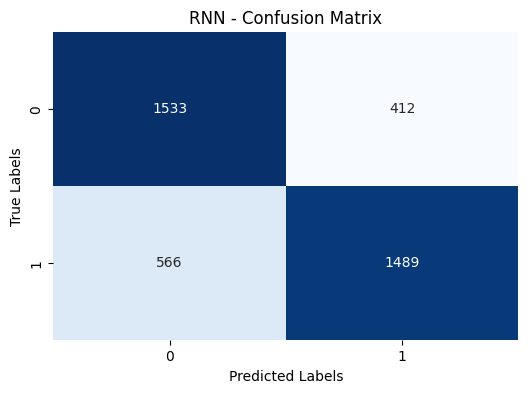

In [18]:
rnn_acc = evaluate_model(rnn_model, "RNN", X_test_pad, y_test)

125/125 [==============================] - 11s 86ms/step

LSTM Model Evaluation:
Accuracy: 0.9748
Confusion Matrix:
[[1916   29]
 [  72 1983]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1945
           1       0.99      0.96      0.98      2055

    accuracy                           0.97      4000
   macro avg       0.97      0.98      0.97      4000
weighted avg       0.97      0.97      0.97      4000



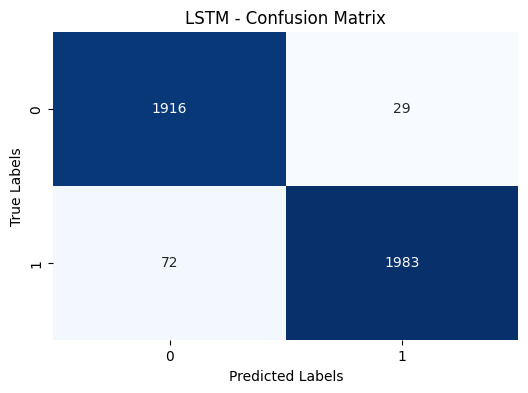

In [19]:
lstm_acc = evaluate_model(lstm_model, "LSTM", X_test_pad, y_test)

125/125 [==============================] - 19s 149ms/step

Word2Vec LSTM Model Evaluation:
Accuracy: 0.9445
Confusion Matrix:
[[1921   24]
 [ 198 1857]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1945
           1       0.99      0.90      0.94      2055

    accuracy                           0.94      4000
   macro avg       0.95      0.95      0.94      4000
weighted avg       0.95      0.94      0.94      4000



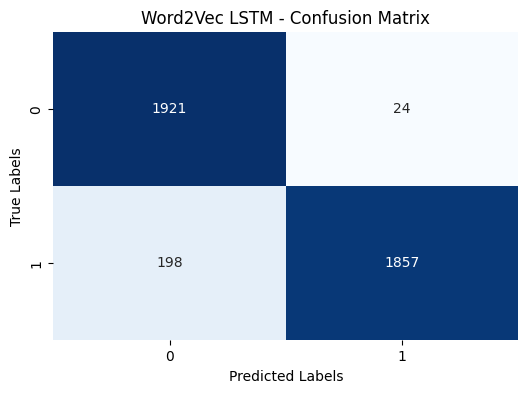

In [20]:
word2vec_lstm_acc = evaluate_model(word2vec_lstm_model, "Word2Vec LSTM", X_test_pad, y_test)

# Plot Training History

In [21]:
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title + ' Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



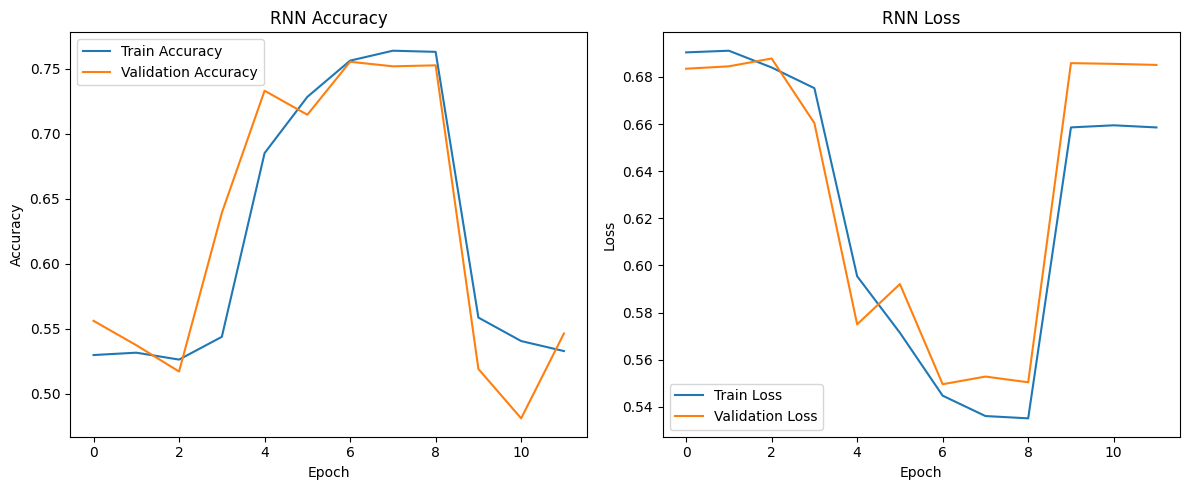

In [22]:
plot_history(rnn_history, "RNN")

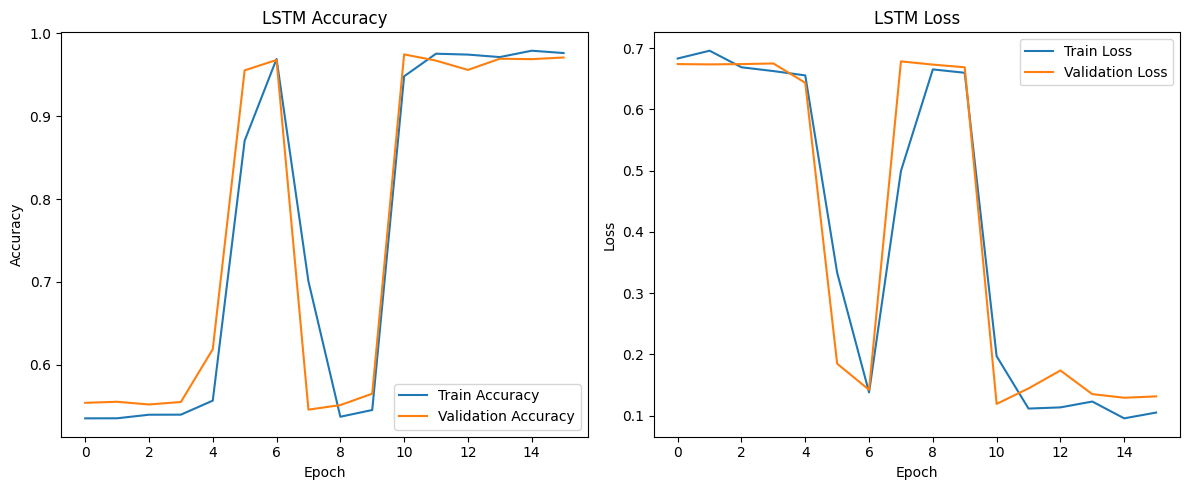

In [23]:
plot_history(lstm_history, "LSTM")

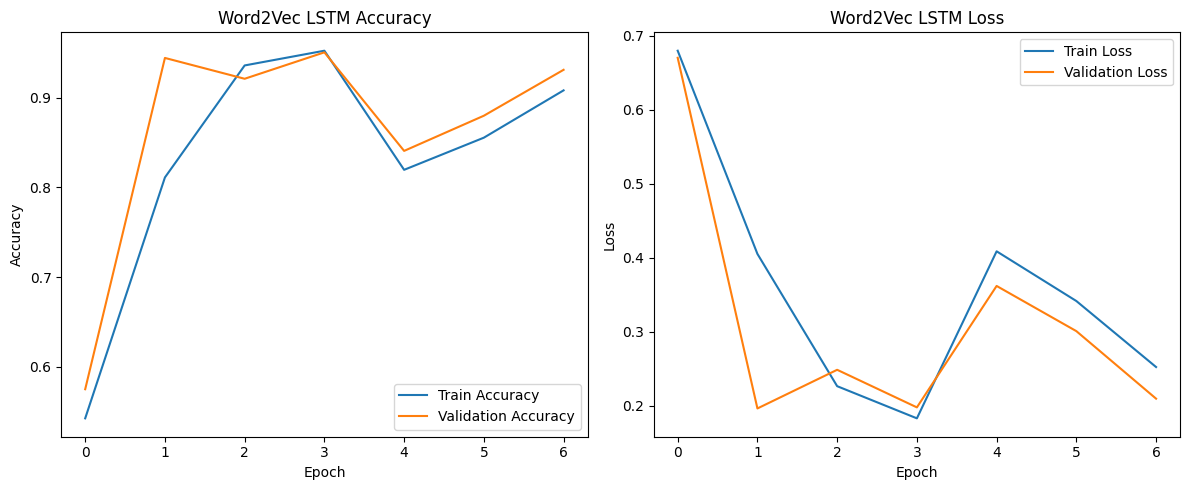

In [24]:
plot_history(word2vec_lstm_history, "Word2Vec LSTM")

# Model Comparison Summary

In [25]:
print("\nModel Comparison:")
print(f"RNN Accuracy:       {rnn_acc:.4f}")
print(f"LSTM Accuracy:      {lstm_acc:.4f}")
print(f"Word2Vec LSTM Accuracy: {word2vec_lstm_acc:.4f}")


Model Comparison:
RNN Accuracy:       0.7555
LSTM Accuracy:      0.9748
Word2Vec LSTM Accuracy: 0.9445


In [26]:
# Save Models
rnn_model.save("/content/drive/MyDrive/AI and ML/Assignment 2/simple_rnn_model.h5")
lstm_model.save("/content/drive/MyDrive/AI and ML/Assignment 2/lstm_model.h5")
word2vec_lstm_model.save("/content/drive/MyDrive/AI and ML/Assignment 2/lstm_word2vec_model.h5")
print("All models saved successfully.")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


All models saved successfully.


In [27]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 129.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00


In [28]:

# Gradio Interface for Real-Time Prediction
import gradio as gr

def gradio_predict(news_text):
    if not news_text.strip():
        return "Error: Empty input!"
    cleaned = preprocess_text(news_text)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    prediction = word2vec_lstm_model.predict(padded)[0][0]
    confidence = prediction if prediction > 0.5 else 1 - prediction
    result = "✅ TRUE NEWS" if prediction < 0.5 else "❌ FAKE NEWS"
    return f"{result} (Confidence: {confidence:.2%})"

iface = gr.Interface(fn=gradio_predict,
                     inputs="text",
                     outputs="text",
                     title="📰 Fake News Detector",
                     description="Enter a news article and see if it's real or fake.")
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c28c67dab90becdc72.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
